In [21]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.data import Data
from numpy.linalg import eigh
from scipy.sparse.linalg import eigsh
from torch_geometric.utils import to_scipy_sparse_matrix
import copy

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix
import numpy as np
import scipy.sparse as sp


# find device
if torch.cuda.is_available(): # NVIDIA
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # apple M1/M2
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cuda')

# Task 1: Implement Laplacian Positional Encodings (LapPE)
 - Compute Laplacian eigenvectors using the graph Laplacian matrix `L = D - A`.
 - Use `eigh` for efficient eigendecomposition (optimized for Hermitian matrices).
 - Handle sign ambiguity in eigenvectors (random flipping or SignNet).
 - Ensure embeddings are robust to sign flips and can capture graph structure.

In [22]:

from scipy.sparse import csgraph



def compute_lap_pe(data, pe_dim=10, use_signnet=False):
    """
    Compute Laplacian Positional Encodings (LapPE) for a given graph data,
    and compute attention scores based on these encodings.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        use_signnet (bool): Whether to handle sign ambiguity using SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'lap_pe',
                                          'attn_scores', and 'attn_weights' attributes added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        # Compute the smallest k+1 eigenvalues and eigenvectors
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except Exception:
        # Fall back to dense computation for small graphs
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Handle sign ambiguity
    if use_signnet:
        # Implement SignNet processing here
        # For simplicity, we'll proceed without SignNet
        pass
    else:
        # Randomly flip signs during training (data augmentation)
        # This helps the model to be robust to sign flips
        sign_flip = np.random.choice([-1, 1], size=(pe.shape[1],))
        pe = pe * sign_flip

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()  # Shape: (num_nodes, pe_dim)
    pe_tensor = pe_tensor.to(data.x.device)  # Ensure the tensor is on the correct device

    # Implement attention mechanism
    # For simplicity, we'll use pe_tensor as both Q and K
    Q = pe_tensor  # Shape: (num_nodes, pe_dim)
    K = pe_tensor  # Shape: (num_nodes, pe_dim)

    # Compute scores
    d = pe_dim
    scores = torch.matmul(Q, K.T) / torch.sqrt(torch.tensor(d, dtype=torch.float32, device=Q.device))

    # Get adjacency matrix and create mask
    adj_torch = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0].to(Q.device)  # Shape: (num_nodes, num_nodes)
    mask = (adj_torch == 0)
    scores = scores.masked_fill(mask, float('-inf'))

    # Optionally, compute attention weights
    attn_weights = F.softmax(scores, dim=1)  # Shape: (num_nodes, num_nodes)

    # Add pe_tensor and attention scores to data
    data.lap_pe = pe_tensor
    data.attn_scores = scores
    data.attn_weights = attn_weights

    return data

Example

In [25]:

# Create a simple graph
# For this example, we'll create a graph with 5 nodes and some edges
edge_index = torch.tensor([
    [0, 1, 2, 3, 0, 2],
    [1, 2, 3, 4, 4, 0]
], dtype=torch.long)

# Create a Data object
data = Data(edge_index=edge_index)

# Set the number of nodes (important if some nodes have no edges)
data.num_nodes = 5

# Optionally, add node features (here we just use ones)
data.x = torch.ones((data.num_nodes, 1))

# Compute the Laplacian Positional Encodings
data = compute_lap_pe(data, pe_dim=3, use_signnet=False)

# Print the computed positional encodings
print("Laplacian Positional Encodings (lap_pe):")
print(data.lap_pe)



NameError: name 'to_dense_adj' is not defined

# Task 2: Combine LapPE with SignNet
   - Implement SignNet to make the model sign-invariant.
   - Use SignNet to process the eigenvectors of the Laplacian to produce consistent embeddings.


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class SignNet(nn.Module):
    """
    SignNet: A neural network that is invariant to the sign flips of input eigenvectors.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super(SignNet, self).__init__()
        self.num_layers = num_layers
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim if _ == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
        self.out_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """
        Forward pass for SignNet.

        Args:
            x (torch.Tensor): Input eigenvectors of shape (num_nodes, in_dim)

        Returns:
            torch.Tensor: Sign-invariant embeddings of shape (num_nodes, out_dim)
        """
        x_pos = self.mlp(x)
        x_neg = self.mlp(-x)
        x = x_pos + x_neg
        x = self.out_layer(x)
        return x


def compute_lap_pe_with_signnet(data, pe_dim=10, hidden_dim=64, out_dim=32, num_layers=2):
    """
    Compute Laplacian Positional Encodings and process them with SignNet.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        pe_dim (int): Number of eigenvectors to compute.
        hidden_dim (int): Hidden dimension for SignNet.
        out_dim (int): Output dimension for SignNet embeddings.
        num_layers (int): Number of layers in SignNet.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'sign_inv_lap_pe' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    from torch_geometric.utils import to_scipy_sparse_matrix
    import numpy as np
    from scipy.sparse import csgraph
    from scipy.sparse.linalg import eigsh
    from numpy.linalg import eigh

    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)

    # Compute the Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=False)

    # For large sparse matrices, use eigsh
    try:
        eigvals, eigvecs = eigsh(laplacian, k=pe_dim+1, which='SM')
        eigvecs = eigvecs[:, eigvals.argsort()]  # Sort eigenvectors
    except RuntimeError:
        laplacian_dense = laplacian.toarray()
        eigvals, eigvecs = eigh(laplacian_dense)
        eigvecs = eigvecs[:, eigvals.argsort()]

    # Exclude the first eigenvector (corresponding to the smallest eigenvalue)
    pe = eigvecs[:, 1:pe_dim+1]

    # Convert to torch tensor
    pe_tensor = torch.from_numpy(pe).float()  # Shape: (num_nodes, pe_dim)

    # Initialize SignNet
    signnet = SignNet(in_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

    # Process the positional encodings with SignNet
    sign_inv_pe = signnet(pe_tensor)  # Shape: (num_nodes, out_dim)

    # Add to data
    data.lap_pe = sign_inv_pe

    return data


## Example


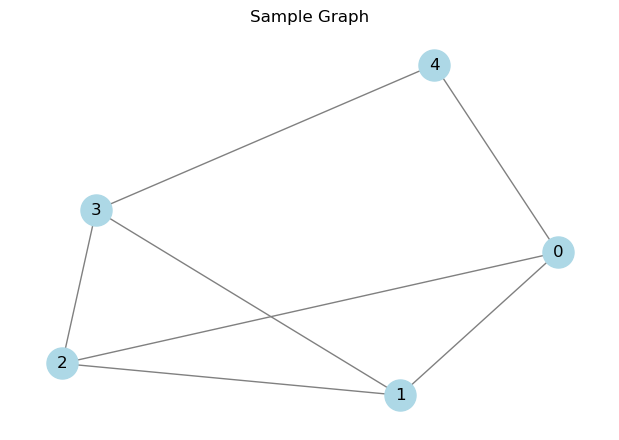

In [27]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple undirected graph
G = nx.Graph()
# Add nodes and edges
G.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 0),
    (1, 3),
    (0, 2)
])

# Visualize the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Sample Graph")
plt.show()


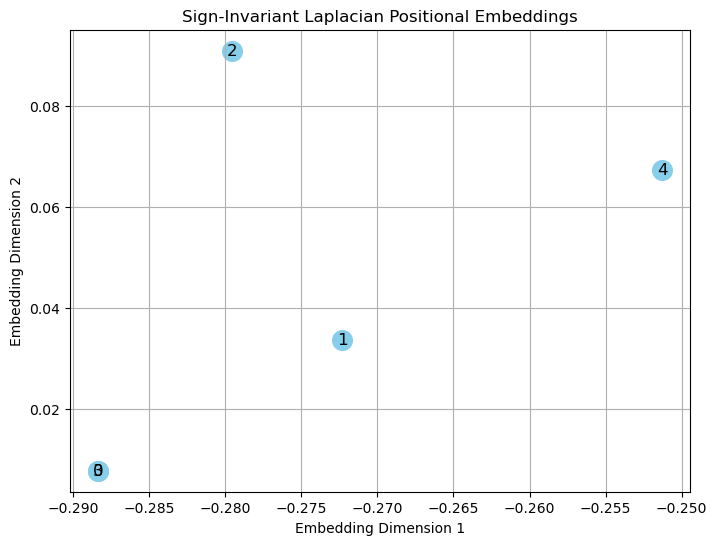

In [28]:
# Convert NetworkX graph to PyTorch Geometric data
from torch_geometric.utils import from_networkx

data = from_networkx(G)
# Ensure the number of nodes is set
data.num_nodes = G.number_of_nodes()

# Optionally, add dummy node features (e.g., ones)
data.x = torch.ones((data.num_nodes, 1))

# Set parameters
pe_dim = 3        # Number of eigenvectors to compute (excluding the first trivial one)
hidden_dim = 32    # Hidden dimension for SignNet
out_dim = 2        # Output dimension for embeddings (for 2D visualization)
num_layers = 2     # Number of layers in SignNet

# Compute sign-invariant Laplacian Positional Encodings
data = compute_lap_pe_with_signnet(data, pe_dim=pe_dim, hidden_dim=hidden_dim, out_dim=out_dim, num_layers=num_layers)

# Extract the embeddings
embeddings = data.lap_pe.detach().numpy()  # Convert to NumPy array for plotting

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='skyblue', s=200)

# Annotate each point with the node index
for i, (x, y) in enumerate(embeddings):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title("Sign-Invariant Laplacian Positional Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()



# Task 3: Implement Random Walk Structural Embeddings (RWSE)
 - Compute RWSE by counting closed walks of a given length `k`:
   - Use the trace of powers of the adjacency matrix: `tr(A^2)`, `tr(A^3)`, ..., `tr(A^k)`.
   - Concatenate these trace values for embeddings.
 - Ensure efficient computation for larger graphs.
 - Compare RWSE with LapPE in terms of performance and computational cost.

In [29]:

def compute_rwse(data, K=5):
    """
    Compute Random Walk Structural Embeddings (RWSE) for a given graph data.

    Args:
        data (torch_geometric.data.Data): Graph data object.
        K (int): Maximum walk length.

    Returns:
        data (torch_geometric.data.Data): Graph data object with 'rwse' attribute added.
    """
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    # Convert to scipy sparse matrix
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).astype(float)
    adj = sp.csr_matrix(adj)

    # Initialize embeddings tensor
    rwse_embeddings = np.zeros((num_nodes, K - 1))

    # Start with A_power = adjacency matrix
    A_power = adj.copy()

    # For walk lengths from 2 to K
    for k in range(2, K + 1):
        # Multiply to get A^k
        A_power = A_power.dot(adj)

        # Get the diagonal entries
        diag_entries = A_power.diagonal()

        # Update embeddings
        rwse_embeddings[:, k - 2] = diag_entries

    # Optionally apply logarithmic scaling to handle large counts
    rwse_embeddings = np.log1p(rwse_embeddings)

    # Convert to torch tensor
    rwse_tensor = torch.from_numpy(rwse_embeddings).float()

    # Add to data
    data.rwse = rwse_tensor

    return data


RWSE Embeddings Shape: torch.Size([34, 2])
RWSE Embeddings:
tensor([[2.8332, 3.6109],
        [2.3026, 3.2189],
        [2.3979, 3.1355],
        [1.9459, 3.0445],
        [1.3863, 1.6094],
        [1.6094, 1.9459],
        [1.6094, 1.9459],
        [1.6094, 2.5649],
        [1.7918, 2.3979],
        [1.0986, 0.0000],
        [1.3863, 1.6094],
        [0.6931, 0.0000],
        [1.0986, 1.0986],
        [1.7918, 2.5649],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.3863, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.0986, 1.0986],
        [1.7918, 2.1972],
        [1.3863, 1.0986],
        [1.3863, 1.0986],
        [1.0986, 1.0986],
        [1.6094, 1.0986],
        [1.3863, 1.0986],
        [1.6094, 2.1972],
        [1.6094, 1.9459],
        [1.9459, 1.9459],
        [2.5649, 3.2958],
        [2.8904, 3.4340]])


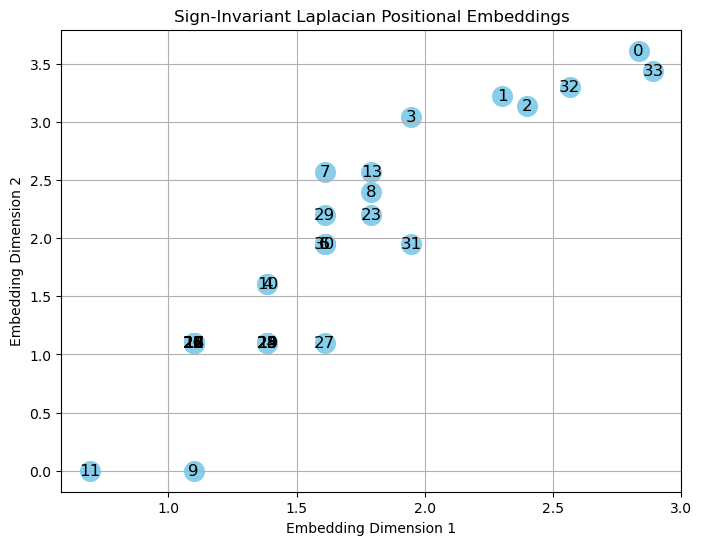

In [30]:
import torch
from torch_geometric.datasets import KarateClub

# Load sample dataset
dataset = KarateClub()
data = dataset[0]

# Compute RWSE embeddings
K = 3  # Maximum walk length
data = compute_rwse(data, K=K)

# Print RWSE embeddings
print("RWSE Embeddings Shape:", data.rwse.shape)
print("RWSE Embeddings:")
print(data.rwse)
embeddings = data.rwse.detach().numpy()

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='skyblue', s=200)

# Annotate each point with the node index
for i, (x, y) in enumerate(embeddings):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

plt.title("Sign-Invariant Laplacian Positional Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()





# Task 4: Implement a Pure Graph Transformer
 - Treat nodes as tokens and apply a standard transformer model.
 - Use global attention to aggregate information across all nodes.
 - Start with node labels as initial embeddings and incorporate LapPE and RWSE.
 - Implement and test the transformer to evaluate its ability to capture graph structure.


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid  # For Cora dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import math

In [57]:


from torch_geometric.utils import to_dense_adj
def create_attention_mask(edge_index, num_nodes, device):
    # Create adjacency matrix
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0].to(device)  # Shape: (num_nodes, num_nodes)

    # Invert adjacency to create mask (True where there is no edge)
    mask = (adj == 0)  # Shape: (num_nodes, num_nodes)

    # nn.MultiheadAttention expects mask of shape (num_nodes, num_nodes)
    # and of type torch.BoolTensor
    mask = mask.to(torch.bool)

    return mask



class GraphTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(GraphTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, attn_mask=None):
        # src shape: (batch_size, num_nodes, d_model)
        # nn.MultiheadAttention expects inputs of shape (sequence_length, batch_size, embedding_dim)
        src = src.transpose(0, 1)  # (num_nodes, batch_size, d_model)

        attn_output, _ = self.self_attn(src, src, src, attn_mask=attn_mask)
        src2 = attn_output.transpose(0, 1)  # (batch_size, num_nodes, d_model)

        src = src.transpose(0, 1)  # Back to (batch_size, num_nodes, d_model)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src



class GraphTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, nhead=8, dropout=0.1):
        super(GraphTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList([
            GraphTransformerEncoderLayer(hidden_dim, nhead, hidden_dim * 4, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # x shape: (num_nodes, input_dim)
        x = self.embedding(x)  # (num_nodes, hidden_dim)
        x = x.unsqueeze(1)  # (num_nodes, batch_size=1, hidden_dim)
        x = x.transpose(0, 1)  # (batch_size=1, num_nodes, hidden_dim)

        for layer in self.layers:
            x = layer(x, attn_mask=attn_mask)

        x = x.transpose(0, 1)  # (num_nodes, batch_size=1, hidden_dim)
        x = x.squeeze(1)       # (num_nodes, hidden_dim)

        # For node classification: output per node
        out = self.classifier(self.dropout(x))  # (num_nodes, num_classes)
        return out

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [58]:
def train(model, optimizer, data, criterion, attn_mask=None):
    model.train()
    optimizer.zero_grad()
    if attn_mask is not None:
        out = model(data.x, attn_mask=attn_mask)
    else:
        out = model(data.x, data.edge_index) if isinstance(model, GCN) else model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model, data, attn_mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, attn_mask=attn_mask)
        preds = logits.argmax(dim=1)
        train_acc = (preds[data.train_mask] == data.y[data.train_mask]).float().mean()
        val_acc = (preds[data.val_mask] == data.y[data.val_mask]).float().mean()
        test_acc = (preds[data.test_mask] == data.y[data.test_mask]).float().mean()
    return train_acc.item(), val_acc.item(), test_acc.item()


def evaluate(model, data, attn_mask=None):
    model.eval()
    with torch.no_grad():
        if attn_mask is not None:
            logits = model(data.x, attn_mask=attn_mask)
        else:
            logits = model(data.x, data.edge_index) if isinstance(model, GCN) else model(data.x)
        preds = logits.argmax(dim=1)
        train_acc = (preds[data.train_mask] == data.y[data.train_mask]).float().mean()
        val_acc = (preds[data.val_mask] == data.y[data.val_mask]).float().mean()
        test_acc = (preds[data.test_mask] == data.y[data.test_mask]).float().mean()
    return train_acc.item(), val_acc.item(), test_acc.item()



In [45]:
# Load the dataset (e.g., Cora)
dataset = Planetoid(root='dataset/Cora', name='Cora')
data = dataset[0]

# Compute LapPE and RWSE
data = compute_lap_pe(data, pe_dim=10)
data = compute_rwse(data, K=5)

# Concatenate node features
data.x = torch.cat([data.x, data.lap_pe, data.rwse], dim=-1)
data = data.to(device)


# Model parameters
input_dim = data.x.shape[1]
hidden_dim = 64
num_classes = dataset.num_classes
num_layers = 2
nhead = 8
dropout = 0.3
attn_mask = create_attention_mask(data.edge_index, data.num_nodes, device)

model = GraphTransformer(input_dim, hidden_dim, num_classes, num_layers, nhead, dropout,)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


# Initialize lists to store training metrics
losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 400
for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer, data, criterion, attn_mask)
    train_acc, val_acc, test_acc = test(model, data, attn_mask)

    # Store metrics for plotting
    losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    # Print metrics at intervals
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot and save the graphs
# Loss plot
plt.figure()
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

# Accuracy plots
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('training_accuracy.png')
plt.close()


Epoch: 10, Loss: 0.1311, Train Acc: 1.0000, Val Acc: 0.6740, Test Acc: 0.6690
Epoch: 20, Loss: 0.0328, Train Acc: 1.0000, Val Acc: 0.6700, Test Acc: 0.6890
Epoch: 30, Loss: 0.0141, Train Acc: 1.0000, Val Acc: 0.7000, Test Acc: 0.7210
Epoch: 40, Loss: 0.0072, Train Acc: 1.0000, Val Acc: 0.7080, Test Acc: 0.7210
Epoch: 50, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7040, Test Acc: 0.7240
Epoch: 60, Loss: 0.0036, Train Acc: 1.0000, Val Acc: 0.7120, Test Acc: 0.7310
Epoch: 70, Loss: 0.0035, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.7320
Epoch: 80, Loss: 0.0031, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.7270
Epoch: 90, Loss: 0.0023, Train Acc: 1.0000, Val Acc: 0.7120, Test Acc: 0.7270
Epoch: 100, Loss: 0.0020, Train Acc: 1.0000, Val Acc: 0.7080, Test Acc: 0.7290
Epoch: 110, Loss: 0.0019, Train Acc: 1.0000, Val Acc: 0.7080, Test Acc: 0.7290
Epoch: 120, Loss: 0.0019, Train Acc: 1.0000, Val Acc: 0.7060, Test Acc: 0.7280
Epoch: 130, Loss: 0.0022, Train Acc: 1.0000, Val Acc: 0.7080,


 #  Task 5: Test the Performance of LapPE and RWSE Embeddings
 - Test LapPE and RWSE embeddings with:
   - A Graph Neural Network (GNN) model.
   - The pure Graph Transformer implemented above.
 - Compare results to understand how the embeddings impact performance.

## Task 6: Test on Datasets
 - Use the following datasets for training and evaluation:
   1. **Peptides-func**:
      - Apply an atom-encoder to represent nodes (atoms in molecules).
      - Combine the atom-encoder embeddings with LapPE and RWSE.
   2. **Cora**:
      - Test embeddings and transformer performance on this graph dataset.

In [66]:
import copy

import copy
import matplotlib.pyplot as plt

def run_experiments(data, model_type='gnn', epochs=200):
    results = []
    data = data.to(device)
    for config in configs:
        exp_data = copy.deepcopy(data)
        exp_data = exp_data.to(device)

        # Prepare features
        features = [exp_data.x.to(device)]  # Base features on GPU
        if config['use_lappe']:
            # Compute LapPE if not already computed
            if not hasattr(exp_data, 'lap_pe'):
                exp_data = compute_lap_pe(exp_data, pe_dim=10)
            features.append(exp_data.lap_pe.to(device))
        if config['use_rwse']:
            # Compute RWSE if not already computed
            if not hasattr(exp_data, 'rwse'):
                exp_data = compute_rwse(exp_data, K=5)
            features.append(exp_data.rwse.to(device))
        exp_data.x = torch.cat(features, dim=-1)  # Concatenate all tensors

        # Initialize model
        input_dim = exp_data.x.shape[1]
        hidden_dim = 64
        num_classes = dataset.num_classes

        if model_type == 'gnn':
            model = GCN(input_dim, hidden_dim, num_classes)
            attn_mask = None  # GCN does not use attn_mask
        elif model_type == 'transformer':
            model = GraphTransformer(input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3)
            # Create attention mask
            attn_mask = create_attention_mask(exp_data.edge_index, exp_data.num_nodes, device)
        else:
            raise ValueError("Invalid model_type: Choose 'gnn' or 'transformer'.")

        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        model = model.to(device)

        # Metrics storage
        losses = []
        train_accuracies = []
        val_accuracies = []
        test_accuracies = []

        # Train and evaluate
        for epoch in range(1, epochs + 1):
            loss = train(model, optimizer, exp_data, criterion, attn_mask)
            train_acc, val_acc, test_acc = evaluate(model, exp_data, attn_mask)

            # Store metrics
            losses.append(loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            test_accuracies.append(test_acc)

            if epoch % 20 == 0:
                print(f"[{config['name']}] Epoch {epoch}, Loss: {loss:.4f}, Train: {train_acc:.4f}, "
                      f"Val: {val_acc:.4f}, Test: {test_acc:.4f}")

        # Save graphs
        # Loss plot
        plt.figure()
        plt.plot(range(1, epochs + 1), losses, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss - {config['name']} - {model_type}")
        plt.legend()
        plt.savefig(f"{model_type}_{config['name']}_loss.png")
        plt.close()

        # Accuracy plot
        plt.figure()
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
        plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy - {config['name']} - {model_type}")
        plt.legend()
        plt.savefig(f"{model_type}_{config['name']}_accuracy.png")
        plt.close()

        results.append({
            'config': config['name'],
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
        })

    return results




In [67]:
configs = [
    {'name': 'Baseline', 'use_lappe': False, 'use_rwse': False},
    {'name': 'LapPE', 'use_lappe': True, 'use_rwse': False},
    {'name': 'RWSE', 'use_lappe': False, 'use_rwse': True},
    {'name': 'LapPE + RWSE', 'use_lappe': True, 'use_rwse': True},
]


In [68]:
results_gnn = run_experiments(data, model_type='gnn')


[Baseline] Epoch 20, Loss: 0.0059, Train: 1.0000, Val: 0.7640, Test: 0.7860
[Baseline] Epoch 40, Loss: 0.0003, Train: 1.0000, Val: 0.7620, Test: 0.7760
[Baseline] Epoch 60, Loss: 0.0002, Train: 1.0000, Val: 0.7620, Test: 0.7760
[Baseline] Epoch 80, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7760
[Baseline] Epoch 100, Loss: 0.0001, Train: 1.0000, Val: 0.7640, Test: 0.7770
[Baseline] Epoch 120, Loss: 0.0001, Train: 1.0000, Val: 0.7640, Test: 0.7770
[Baseline] Epoch 140, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7780
[Baseline] Epoch 160, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7780
[Baseline] Epoch 180, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7790
[Baseline] Epoch 200, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7790
[LapPE] Epoch 20, Loss: 0.0046, Train: 1.0000, Val: 0.7700, Test: 0.7910
[LapPE] Epoch 40, Loss: 0.0002, Train: 1.0000, Val: 0.7640, Test: 0.7810
[LapPE] Epoch 60, Loss: 0.0001, Train: 1.0000, Val: 0.7620, Test: 0.7820
[LapPE] Epoch 8

In [69]:
# Run experiments with Transformer
results_transformer = run_experiments(data, model_type='transformer', epochs=300)

[Baseline] Epoch 20, Loss: 0.0171, Train: 1.0000, Val: 0.7020, Test: 0.7100
[Baseline] Epoch 40, Loss: 0.0021, Train: 1.0000, Val: 0.7240, Test: 0.7450
[Baseline] Epoch 60, Loss: 0.0008, Train: 1.0000, Val: 0.7100, Test: 0.7320
[Baseline] Epoch 80, Loss: 0.0007, Train: 1.0000, Val: 0.7080, Test: 0.7260
[Baseline] Epoch 100, Loss: 0.0008, Train: 1.0000, Val: 0.7080, Test: 0.7310
[Baseline] Epoch 120, Loss: 0.0007, Train: 1.0000, Val: 0.7180, Test: 0.7360
[Baseline] Epoch 140, Loss: 0.0010, Train: 1.0000, Val: 0.7220, Test: 0.7340
[Baseline] Epoch 160, Loss: 0.0004, Train: 1.0000, Val: 0.7220, Test: 0.7350
[Baseline] Epoch 180, Loss: 0.0009, Train: 1.0000, Val: 0.7220, Test: 0.7350
[Baseline] Epoch 200, Loss: 0.0003, Train: 1.0000, Val: 0.7240, Test: 0.7360
[Baseline] Epoch 220, Loss: 0.0003, Train: 1.0000, Val: 0.7260, Test: 0.7390
[Baseline] Epoch 240, Loss: 0.0002, Train: 1.0000, Val: 0.7260, Test: 0.7380
[Baseline] Epoch 260, Loss: 0.0003, Train: 1.0000, Val: 0.7220, Test: 0.7380
[Ba

# Implement and Test on the Peptides-func Dataset

In [70]:
import torch
import torch_geometric as pyg
from torch_geometric.nn import MessagePassing, global_mean_pool
import torch.optim as optim
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import networkx as nx
import torch.nn as nn
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.datasets import TUDataset
from tqdm import tqdm


class GINELayerWithVN(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super(GINELayerWithVN, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(out_channels, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )
        self.edge_encoder = torch.nn.Linear(edge_dim, out_channels)
        # Remove node_encoder from here
        self.virtual_node_mlp = torch.nn.Sequential(
            torch.nn.Linear(out_channels, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels),
            torch.nn.ReLU(),
        )
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.edge_encoder.weight)
        for m in self.mlp:
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        for m in self.virtual_node_mlp:
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x, edge_index, edge_attr, vn_embed, batch):
        # x is already encoded via node_encoder in the main model
        x = x.float()  # Ensure x is FloatTensor
        edge_attr = edge_attr.float()  # Ensure edge_attr is FloatTensor
        edge_attr = self.edge_encoder(edge_attr)

        # Add virtual node embedding to node features
        vn_expanded = vn_embed[batch]
        x = x + vn_expanded

        # Message Passing
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        # Update node embeddings
        out = self.mlp(out)
        return out

    def message(self, x_j, edge_attr):
        # Compute messages
        return x_j + edge_attr

    def update(self, aggr_out):
        return aggr_out

# Laplacian Positional Encodings (LapPE)
def compute_laplace_pe(data, num_eigenvec=10):
    G = to_networkx(data, to_undirected=True)
    A = nx.adjacency_matrix(G).astype(float)
    num_nodes = A.shape[0]
    D = np.diag(np.array(A.sum(axis=1)).flatten())
    L = D - A.todense()
    L = torch.tensor(L, dtype=torch.float, device=device)
    try:
        eigenvalues, eigenvectors = torch.linalg.eigh(L)
    except RuntimeError:
        eigenvalues, eigenvectors = torch.symeig(L, eigenvectors=True)
    available_eigenvec = eigenvectors.shape[1] - 1
    actual_num_eigenvec = min(num_eigenvec, available_eigenvec)
    eigenvectors = eigenvectors[:, 1:1 + actual_num_eigenvec]
    if actual_num_eigenvec < num_eigenvec:
        pad_size = num_eigenvec - actual_num_eigenvec
        padding = torch.zeros(eigenvectors.shape[0], pad_size, device=device)
        eigenvectors = torch.cat([eigenvectors, padding], dim=1)
    return eigenvectors  # Shape: (num_nodes, num_eigenvec)

# Random Walk Structural Embeddings (RWSE)
def compute_rwse(data, walk_length=10):
    G = to_networkx(data, to_undirected=True)
    A = nx.adjacency_matrix(G).astype(float)
    A = A.todense()
    num_nodes = A.shape[0]
    A = torch.tensor(A, dtype=torch.float, device=device)
    rw_features = []
    A_power = A.clone()
    for _ in range(walk_length):
        diag = torch.diagonal(A_power)
        rw_features.append(diag)
        A_power = torch.matmul(A_power, A)
    rwse = torch.stack(rw_features, dim=1)  # (num_nodes, walk_length)
    return rwse  # Shape: (num_nodes, walk_length)

# SignNet to ensure sign invariance
class SignNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SignNet, self).__init__()
        self.phi = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x):
        return self.phi(x) + self.phi(-x)

# Graph Transformer Layer with Masking
class GraphTransformerLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super(GraphTransformerLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=in_dim, num_heads=num_heads, dropout=dropout)
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(out_dim, in_dim)
        self.norm1 = nn.LayerNorm(in_dim)
        self.norm2 = nn.LayerNorm(in_dim)
        self.activation = nn.ReLU()

    def forward(self, x, key_padding_mask=None):
        # x: (sequence_length, batch_size, embed_dim)
        attn_output, _ = self.self_attn(x, x, x, key_padding_mask=key_padding_mask)
        x = x + attn_output
        x = self.norm1(x)
        linear_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + linear_output
        x = self.norm2(x)
        return x

# Updated GNN Model with Virtual Node, GINE Layers, and Graph Transformer
class GNNWithVirtualNodeAndGINEAndTransformer(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, edge_attr_dim, num_layers=5, lap_pe_dim=10, rwse_dim=10):
        super(GNNWithVirtualNodeAndGINEAndTransformer, self).__init__()
        self.num_layers = num_layers
        self.hidden_features = hidden_features

        # Node Encoder
        self.node_encoder = nn.Linear(in_features, hidden_features)

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(GINELayerWithVN(
                in_channels=hidden_features,
                out_channels=hidden_features,
                edge_dim=edge_attr_dim
            ))

        self.virtual_node_embedding = torch.nn.Embedding(1, hidden_features)
        torch.nn.init.constant_(self.virtual_node_embedding.weight.data, 0)

        self.mlp_virtual_node = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_features, hidden_features),
            torch.nn.ReLU(),
        )

        # Positional Encodings
        self.lap_pe_dim = lap_pe_dim
        self.rwse_dim = rwse_dim
        self.lap_pe_linear = nn.Linear(hidden_features, hidden_features)
        self.rwse_linear = nn.Linear(rwse_dim, hidden_features)
        self.signnet = SignNet(lap_pe_dim, hidden_features)

        # Graph Transformer
        self.transformer_layers = nn.ModuleList([
            GraphTransformerLayer(hidden_features, hidden_features) for _ in range(3)
        ])

        self.fc = torch.nn.Linear(hidden_features, out_features)

    def forward(self, x, edge_index, edge_attr, batch, data):
        # Apply node_encoder first
        x = self.node_encoder(x)  # [num_nodes, hidden_features]
        # Initialize positional encodings tensor
        pos_enc = torch.zeros_like(x).to(device)  # [num_nodes, hidden_features]

        # Iterate over each graph in the batch
        num_graphs = batch.max().item() + 1
        for graph_id in range(num_graphs):
            mask = (batch == graph_id)
            num_nodes_graph = mask.sum().item()

            # Extract node indices for the current graph
            node_idx = torch.where(batch == graph_id)[0]

            # Extract subgraph using pyg.utils.subgraph
            sub_edge_index, sub_edge_attr = pyg.utils.subgraph(
                node_idx,
                edge_index,
                edge_attr,
                relabel_nodes=True,
                num_nodes=x.size(0)
            )

            # Create sub_data
            sub_data = pyg.data.Data(
                x=x[node_idx],
                edge_index=sub_edge_index,
                edge_attr=sub_edge_attr
            )

            # Compute Positional Encodings for the sub-graph
            lap_pe = compute_laplace_pe(sub_data, num_eigenvec=self.lap_pe_dim)
            rwse = compute_rwse(sub_data, walk_length=self.rwse_dim)

            # Apply SignNet to LapPE
            lap_pe = self.signnet(lap_pe)  # [num_nodes_graph, hidden_features]

            # Linear transformation
            lap_pe = self.lap_pe_linear(lap_pe)  # [num_nodes_graph, hidden_features]
            rwse = self.rwse_linear(rwse)        # [num_nodes_graph, hidden_features]

            # Combine positional encodings
            graph_pos_enc = lap_pe + rwse  # [num_nodes_graph, hidden_features]

            # Assign to pos_enc
            pos_enc[node_idx] = graph_pos_enc  # [num_nodes, hidden_features]

        # Add positional encodings to node features
        x = x + pos_enc  # [num_nodes, hidden_features]

        # Initialize virtual node embedding
        batch_size = num_graphs
        vn_embed = self.virtual_node_embedding.weight.repeat(batch_size, 1)  # [batch_size, hidden_features]

        for conv in self.convs:
            x = conv(x, edge_index, edge_attr, vn_embed, batch)  # [num_nodes, hidden_features]
            x = F.relu(x)

            # Update virtual node embedding
            vn_aggr = global_mean_pool(x, batch)  # [batch_size, hidden_features]
            vn_embed = vn_embed + self.mlp_virtual_node(vn_aggr)  # [batch_size, hidden_features]

        # Prepare for Graph Transformer
        # Group node features by graph and pad
        x_padded, mask = pyg.utils.to_dense_batch(x, batch)  # x_padded: [batch_size, max_num_nodes, hidden_features]

        # Transpose to match expected input of Transformer
        x_padded = x_padded.transpose(0, 1)  # x_padded: [max_num_nodes, batch_size, hidden_features]

        # mask remains of shape [batch_size, max_num_nodes], which matches key_padding_mask
        # Invert mask for key_padding_mask (True indicates positions to be masked)
        key_padding_mask = ~mask  # [batch_size, max_num_nodes]

        # Apply Transformer layers
        for transformer in self.transformer_layers:
            x_padded = transformer(x_padded, key_padding_mask=key_padding_mask)

        # Transpose back
        x_padded = x_padded.transpose(0, 1)  # x_padded: [batch_size, max_num_nodes, hidden_features]

        # Flatten x_padded back to x
        x = x_padded[mask]  # x: [num_nodes, hidden_features]

        # Apply global mean pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_features]
        x = self.fc(x)  # [batch_size, out_features]
        return x

# Training and evaluation functions
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training'):
        batch = batch.to(device)
        batch.x = batch.x.float()  # Convert node features to float
        batch.edge_attr = batch.edge_attr.float()  # Convert edge attributes to float
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch, batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(loader)
    return average_loss

def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            batch = batch.to(device)
            batch.x = batch.x.float()  # Convert node features to float
            batch.edge_attr = batch.edge_attr.float()  # Convert edge attributes to float
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch, batch)
            y_pred.append(out.cpu())
            y_true.append(batch.y.cpu())
    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()
    # Compute per-class AP
    ap_per_class = []
    for i in range(y_true.shape[1]):
        try:
            ap = average_precision_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            ap = 0.0  # Handle cases where a class has no positive samples
        ap_per_class.append(ap)
    mean_ap = np.mean(ap_per_class)
    return mean_ap

def plot_results(epochs, train_losses, val_aps, learning_rates=None):
    epochs_range = range(1, epochs + 1)

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('Training_Loss.png')
    plt.show()

    # Plot Validation AP Score
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, val_aps, label='Validation AP Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Average Precision Score')
    plt.title('Validation AP Score over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('Validation_AP_Score.png')
    plt.show()

    # Plot Learning Rate if provided
    if learning_rates is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs_range, learning_rates, label='Learning Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate over Epochs')
        plt.legend()
        plt.grid(True)
        plt.savefig('Learning_Rate.png')
        plt.show()

def main(epochs=100, lr=0.001, hidden_features=256):
    # Compute edge_attr_dim and num_tasks from the dataset
    edge_attr_dim = dataset[0].edge_attr.shape[1]
    num_tasks = dataset[0].y.shape[-1]

    # Initialize the model, optimizer, and loss function
    model = GNNWithVirtualNodeAndGINEAndTransformer(
        in_features=dataset.num_node_features,
        hidden_features=hidden_features,
        out_features=num_tasks,
        edge_attr_dim=edge_attr_dim,
        num_layers=5,  # Increased depth as per the paper's suggestion
        lap_pe_dim=10,
        rwse_dim=10
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=10)

    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Lists to store losses and AP scores
    train_losses = []
    val_aps = []
    learning_rates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, loss_fn)
        val_ap = evaluate(model, val_loader)
        train_losses.append(train_loss)
        val_aps.append(val_ap)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        print(f"Train Loss: {train_loss:.4f}, Validation AP Score: {val_ap:.4f}, Learning Rate: {current_lr:.6f}")
        scheduler.step(val_ap)

    # Final test evaluation
    test_ap = evaluate(model, test_loader)
    print(f"Test AP Score: {test_ap:.4f}")

    # Plotting the results
    plot_results(epochs, train_losses, val_aps, learning_rates)


In [71]:
try:
    dataset = pyg.datasets.LRGBDataset(root='dataset/peptides-func', name="Peptides-func")
except AttributeError:
    # If LRGBDataset is not available, use a placeholder
    # Replace this with the actual dataset loader you're using
    print("LRGBDataset not found. Please replace with the actual dataset loader.")
    dataset = TUDataset(root='dataset/Mutagenicity', name='Mutagenicity')

    # Check if dataset has splits; if not, create them manually
if hasattr(dataset, 'train_val_test_idx'):
    peptides_train = dataset[dataset.train_val_test_idx['train']]
    peptides_val = dataset[dataset.train_val_test_idx['val']]
    peptides_test = dataset[dataset.train_val_test_idx['test']]
else:
    # Create train, val, test splits manually
    num_train = int(0.8 * len(dataset))
    num_val = int(0.1 * len(dataset))
    num_test = len(dataset) - num_train - num_val
    peptides_train, peptides_val, peptides_test = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

batch_size = 32
train_loader = pyg.loader.DataLoader(peptides_train, batch_size=batch_size, shuffle=True)
val_loader = pyg.loader.DataLoader(peptides_val, batch_size=batch_size, shuffle=False)
test_loader = pyg.loader.DataLoader(peptides_test, batch_size=batch_size, shuffle=False)

# Check number of classes and label distribution
if hasattr(dataset, 'num_tasks'):
    num_classes = dataset.num_tasks
elif hasattr(dataset, 'num_classes'):
    num_classes = dataset.num_classes
else:
    # Assume binary classification if not specified
    num_classes = 1
print(f"Number of classes: {num_classes}")

all_labels = np.concatenate([data.y.numpy() for data in dataset], axis=0)
label_distribution = np.mean(all_labels, axis=0)
print(f"Label distribution: {label_distribution}")

# Run the main training loop
main(epochs=300, lr=0.001, hidden_features=32)




Number of classes: 10
Label distribution: [0.08884393 0.03540881 0.06419571 0.06226432 0.6272418  0.19755358
 0.10687023 0.18412581 0.01995769 0.2598179 ]
Epoch 1/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Train Loss: 0.3706, Validation AP Score: 0.2254, Learning Rate: 0.001000
Epoch 2/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


Train Loss: 0.3564, Validation AP Score: 0.2176, Learning Rate: 0.001000
Epoch 3/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


Train Loss: 0.3440, Validation AP Score: 0.2354, Learning Rate: 0.001000
Epoch 4/300


Evaluating: 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]


Train Loss: 0.3405, Validation AP Score: 0.2357, Learning Rate: 0.001000
Epoch 5/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.22it/s]


Train Loss: 0.3453, Validation AP Score: 0.1844, Learning Rate: 0.001000
Epoch 6/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


Train Loss: 0.3503, Validation AP Score: 0.2355, Learning Rate: 0.001000
Epoch 7/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.16it/s]


Train Loss: 0.3414, Validation AP Score: 0.2303, Learning Rate: 0.001000
Epoch 8/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.14it/s]


Train Loss: 0.3378, Validation AP Score: 0.2175, Learning Rate: 0.001000
Epoch 9/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


Train Loss: 0.3341, Validation AP Score: 0.2270, Learning Rate: 0.001000
Epoch 10/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


Train Loss: 0.3396, Validation AP Score: 0.1979, Learning Rate: 0.001000
Epoch 11/300


Evaluating: 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]


Train Loss: 0.3333, Validation AP Score: 0.1871, Learning Rate: 0.001000
Epoch 12/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]


Train Loss: 0.3358, Validation AP Score: 0.1868, Learning Rate: 0.001000
Epoch 13/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


Train Loss: 0.3420, Validation AP Score: 0.2145, Learning Rate: 0.001000
Epoch 14/300


Evaluating: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


Train Loss: 0.3439, Validation AP Score: 0.1864, Learning Rate: 0.001000
Epoch 15/300


Evaluating: 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]


Train Loss: 0.3324, Validation AP Score: 0.1899, Learning Rate: 0.001000
Epoch 16/300


Training:  15%|█▌        | 41/272 [00:12<01:10,  3.29it/s]


KeyboardInterrupt: 